# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators=10, max_depth=10, learning_rate=0.1, random_state=42):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.random_state = random_state

        self.estimators = []
        self.gammas = []

    def fit(self, x, y) -> any:
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        np.random.seed(self.random_state)
        y_composition = np.zeros_like(y)
        for _ in range(self.n_estimators):
            y_composition = y_composition + self._fit_predict_tree(x, y, y_composition)

        return self

    def _fit_predict_tree(self, x, y, y_composition):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(x, y - y_composition)
        gamma = minimize(lambda g_guess: mean_squared_error(y, y_composition + g_guess * tree.predict(x)),
                         np.array([1]),
                         method='Nelder-Mead').x[0]
        # gamma = 1
        self.estimators.append(tree)
        self.gammas.append(gamma)
        return gamma * self.learning_rate * tree.predict(x)

    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        predictions = np.array([est.predict(x) for est in self.estimators])
        scaled_predictions = predictions * np.asarray(self.gammas).reshape(-1, 1) * self.learning_rate
        y_pred = scaled_predictions.sum(axis=0)
        return y_pred

    def get_params(self, deep=True):
        return {'max_depth': self.max_depth,
                'n_estimators': self.n_estimators,
                'learning_rate': self.learning_rate,
                'random_state': self.random_state}

    def set_params(self, **params):
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Calif

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
# from sklearn.model_selection import GridSearchCV
#
# parameters = {'max_depth': range(1, 14, 3),
#               'n_estimators': range(5, 101, 5),
#               'learning_rate': np.linspace(0.001, 1, 10),
#               'random_state': [19052019]}
# grid = GridSearchCV(GradientBoosting(), parameters, scoring='max_error', n_jobs=-1, refit=True)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# mean_squared_error(y_test, grid.predict(X_test))

> Ооооочень долго и практически абсолютно бесполезно - итоговая модель хорошо подогнана под обучающую выборку, но отвратительно работает на тестовой (MSE ~16)

Min MSE = 9.422409008102628 at learning rate = 0.5975175175175175


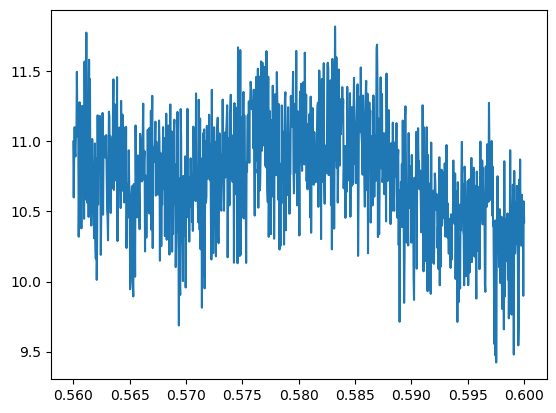

In [7]:
import matplotlib.pyplot as plt

# да, долго, но иначе никак
x = np.linspace(0.56, 0.6, 1000)
y = [mean_squared_error(y_test, GradientBoosting(50, 9, i, 19052019).fit(X_train, y_train).predict(X_test)) for i in x]
im = np.argmin(y)
print(f'Min MSE = {y[im]} at learning rate = {x[im]}')
plt.plot(x, y)
plt.show()

> Избавлю вычисляющий все это компьютер от мучений и сразу скажу, что минимальное MSE - 9.422

> В результате наблюдений было выяснено примерно следующее:
> - После нескольких десятков эстиматоров значение модели практически перестает меняться, поэтому иметь больше порядка 50 смысла не имеет
> - Наилучшие значения глубины находятся в районе 7-10
> - Модель очень чувствительна к скорости обучения - по графику сверху можно увидеть, что роль играют даже десятитысячные доли.

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [8]:
train = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [9]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler


def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    data.dropna(inplace=True)
    data[['Month', 'DayofMonth', 'DayOfWeek']] = data[['Month', 'DayofMonth', 'DayOfWeek']].apply(
        LabelEncoder().fit_transform)
    data['DepTime'] = data['DepTime'].apply(lambda val: val // 100 * 100 + round((val % 100 / 60) * 100))
    data = pd.get_dummies(data, columns=['UniqueCarrier', 'Origin', 'Dest'], drop_first=True)
    data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda val: 1 if val == 'Y' else 0)

    data[['DepTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek']] = StandardScaler().fit_transform(
        data[['DepTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek']]
    )
    return data

In [11]:
train = preprocess(train)
train

,Month,DayofMonth,DayOfWeek,DepTime,Distance,dep_delayed_15min,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,...,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,1.285908,-0.203729,1.530490,1.251039,0.004530,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.126882,-0.315427,-0.477915,0.459382,0.182040,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.575665,-0.427125,0.526288,0.159098,-0.545405,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.032145,0.243064,1.028389,-0.706056,0.248172,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.321902,1.471745,1.028389,1.020052,-0.533223,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.416638,1.136650,-0.477915,0.564376,-0.923050,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,-1.611659,-0.650521,-0.477915,-1.163831,0.269055,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99997,-1.611659,0.131366,-0.980016,1.135545,0.603192,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,0.126882,0.466461,0.024186,0.343888,-1.025727,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train = train.drop(columns=['dep_delayed_15min'])
y_train = train['dep_delayed_15min']
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [13]:
from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7415806735358654

In [14]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=False)
cat_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cat_model.predict_proba(X_valid)[:, 1])

0.7452549773007368

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [15]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [16]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples, dist_measure: str = 'euclidean'):
        self.eps = eps
        self.min_samples = min_samples
        self.dist_matrix = None
        self.dist_measure = dist_measure
        self.n_clusters = 0
        self.labels = None

    def fit_predict(self, X):
        self.n_clusters = 0
        # Помечаем все точки, как необработанные
        self.labels = - np.ones(X.shape[0])

        # Создаем матрицу расстояний
        self.dist_matrix = distance.cdist(X, X, self.dist_measure)

        for i, point in enumerate(X):
            # Пропустить точку, если она уже рассмотрена
            if self.labels[i] != -1:
                continue
            # Найти всех соседей
            neighbours = self._range_query(i)

            # Проверить, является ли точка шумовой
            if len(neighbours) < self.min_samples:
                self.labels[i] = 0
                continue

            # Если соседей больше min_samples - мы нашли основную точку. Наращиваем кластер
            self.n_clusters += 1
            self._grow_cluster(i, neighbours)

        return self.labels

    def _grow_cluster(self, root, neighbours):
        self.labels[root] = self.n_clusters

        while neighbours:
            i = neighbours.pop()
            # Точка уже является частью другого кластера
            if self.labels[i] > 0:
                continue
            # Помечаем точку, как часть кластера. В том числе если раньше она была помечена, как шумовая
            self.labels[i] = self.n_clusters
            # Находим соседей точки
            new_neighbours = self._range_query(i)
            # Если у точки достаточно соседей - она основная и от нее можно расширятся дальше
            # В противном случае точка просто достижима и ее соседей добавить в кластер мы не можем
            if len(new_neighbours) >= self.min_samples:
                neighbours.update(new_neighbours)

    def _range_query(self, i):
        return set(np.nonzero(self.dist_matrix[i] <= self.eps)[0])

Проверим себя на простом примере:

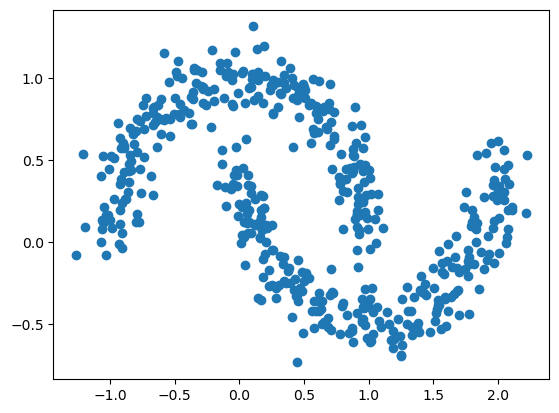

In [17]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

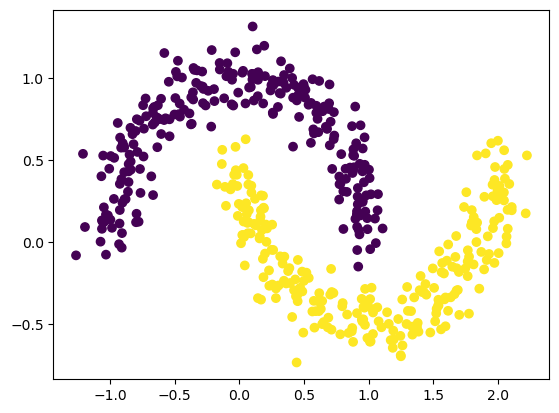

In [18]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()

Референс:

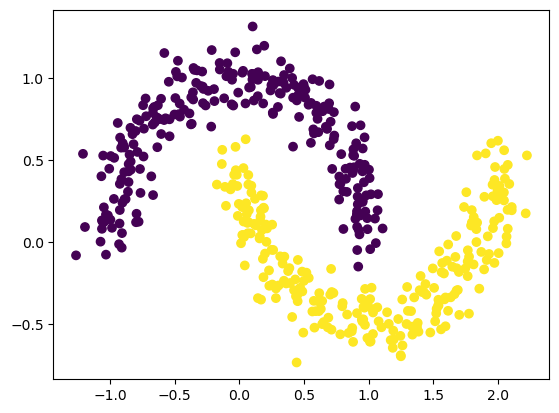

In [20]:
from sklearn.cluster import DBSCAN
# from sklearn.utils.fixes import _astype_copy_false

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [21]:
# Взято из официальной документации sklearn
# https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py

from sklearn.datasets import make_circles, make_blobs

n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [noisy_circles, noisy_moons, blobs, aniso, varied]
epsilons = [0.1, 0.1, 1, 0.25, 0.7]

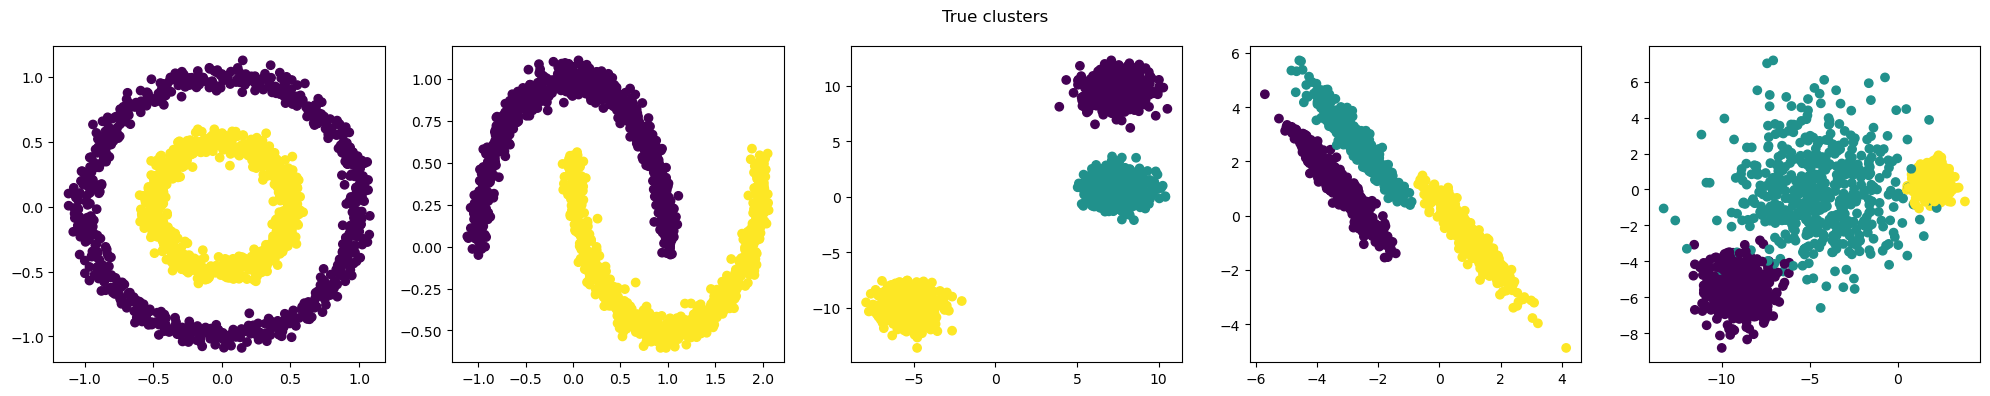

In [22]:
plt.figure(figsize=(20, 4))
for i, X in enumerate(datasets):
    plt.subplot(1, 5, i + 1)
    plt.scatter(X[0][:, 0], X[0][:, 1], c=X[1])
plt.suptitle('True clusters')
plt.tight_layout()
plt.show()

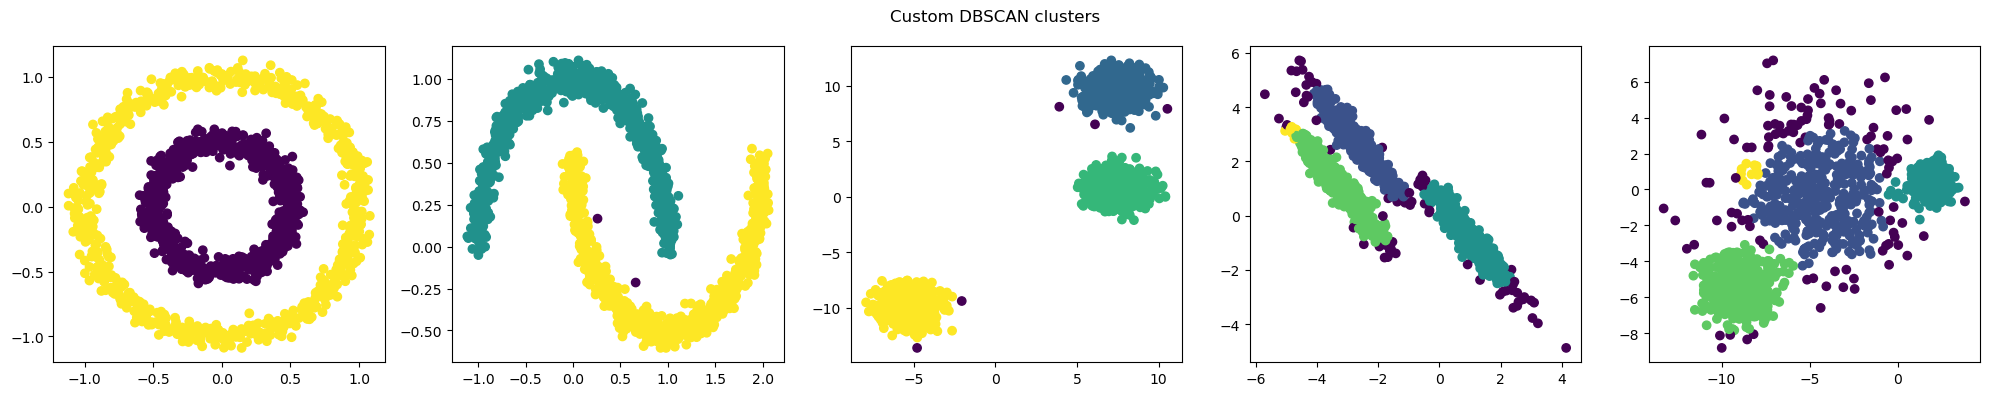

In [23]:
plt.figure(figsize=(20, 4))
for i, X in enumerate(datasets):
    clusters = dbscan(eps=epsilons[i], min_samples=10).fit_predict(X[0])
    plt.subplot(1, 5, i + 1)
    plt.scatter(X[0][:, 0], X[0][:, 1], c=clusters)
plt.suptitle('Custom DBSCAN clusters')
plt.tight_layout()
plt.show()

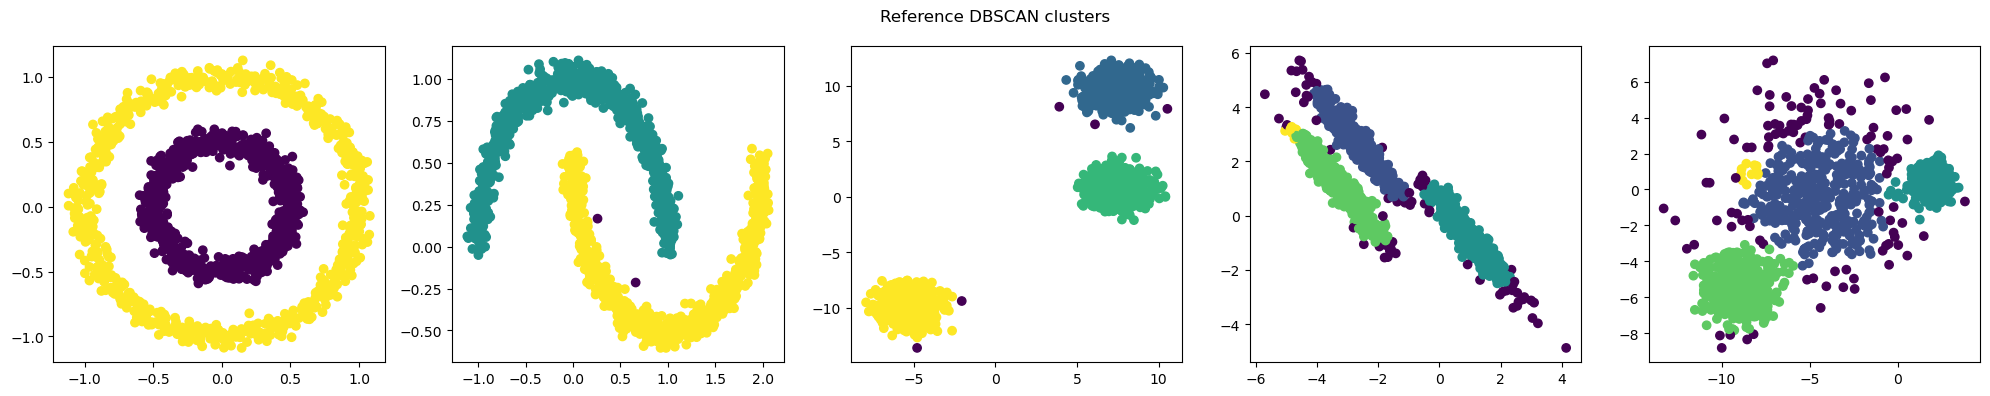

In [24]:
plt.figure(figsize=(20, 4))
for i, X in enumerate(datasets):
    clusters = DBSCAN(eps=epsilons[i], min_samples=10).fit_predict(X[0])
    plt.subplot(1, 5, i + 1)
    plt.scatter(X[0][:, 0], X[0][:, 1], c=clusters)
plt.suptitle('Reference DBSCAN clusters')
plt.tight_layout()
plt.show()

> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:


In [25]:
%%time
%%capture
for X in datasets:
    clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X[0])

CPU times: user 74.7 ms, sys: 8.14 ms, total: 82.9 ms
Wall time: 82.9 ms


In [26]:
%%time
%%capture
for X in datasets:
    clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X[0])

CPU times: user 19 ms, sys: 1.53 ms, total: 20.5 ms
Wall time: 19.1 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло?

In [27]:
train = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
X = train[['DepTime', 'Distance']].to_numpy()

Clusters = 125


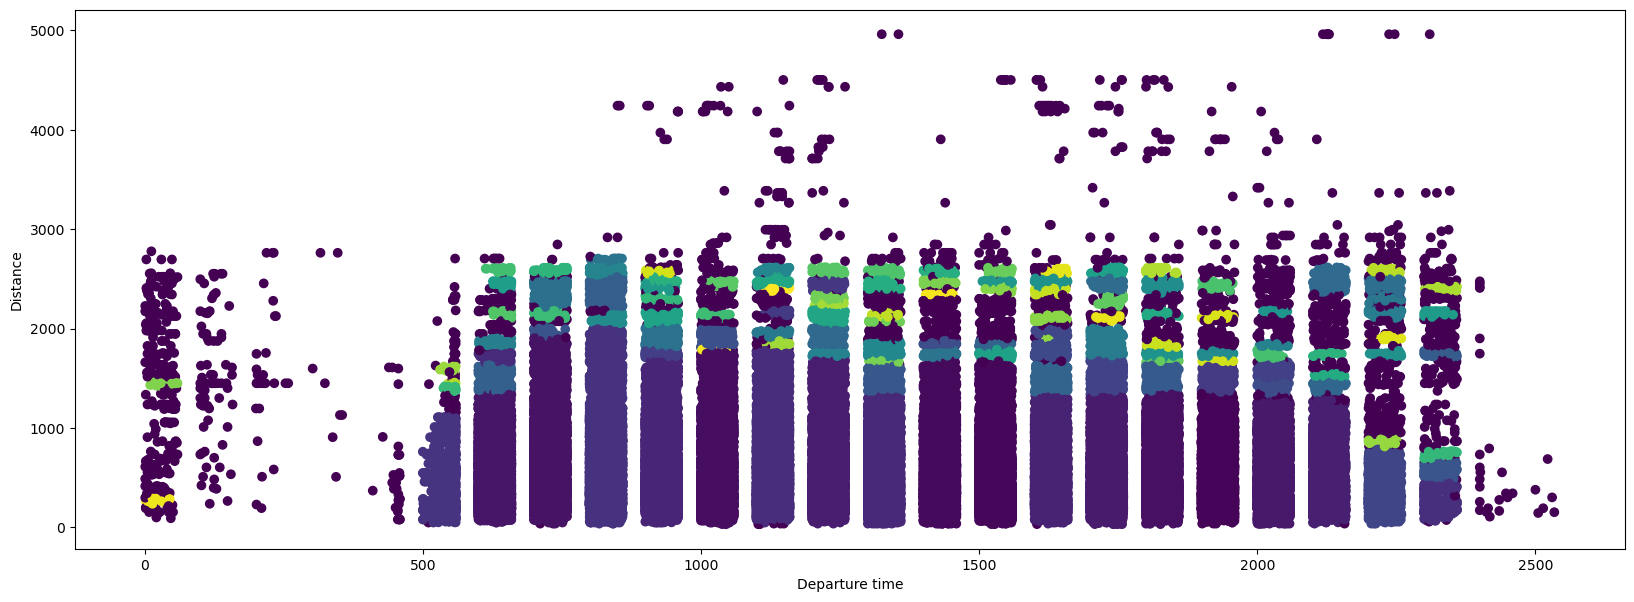

In [28]:
plt.figure(figsize=(20, 7))
clusters = DBSCAN(eps=30, min_samples=20).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.xlabel('Departure time')
plt.ylabel('Distance')
print('Clusters =', max(clusters))
plt.show()

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ При больших значениях `eps` и низких `min_samples` - большая окрестность позволяет находить больше соседей, а если их все равно мало, то низкий порог все равно дает возможность считать точку основной.

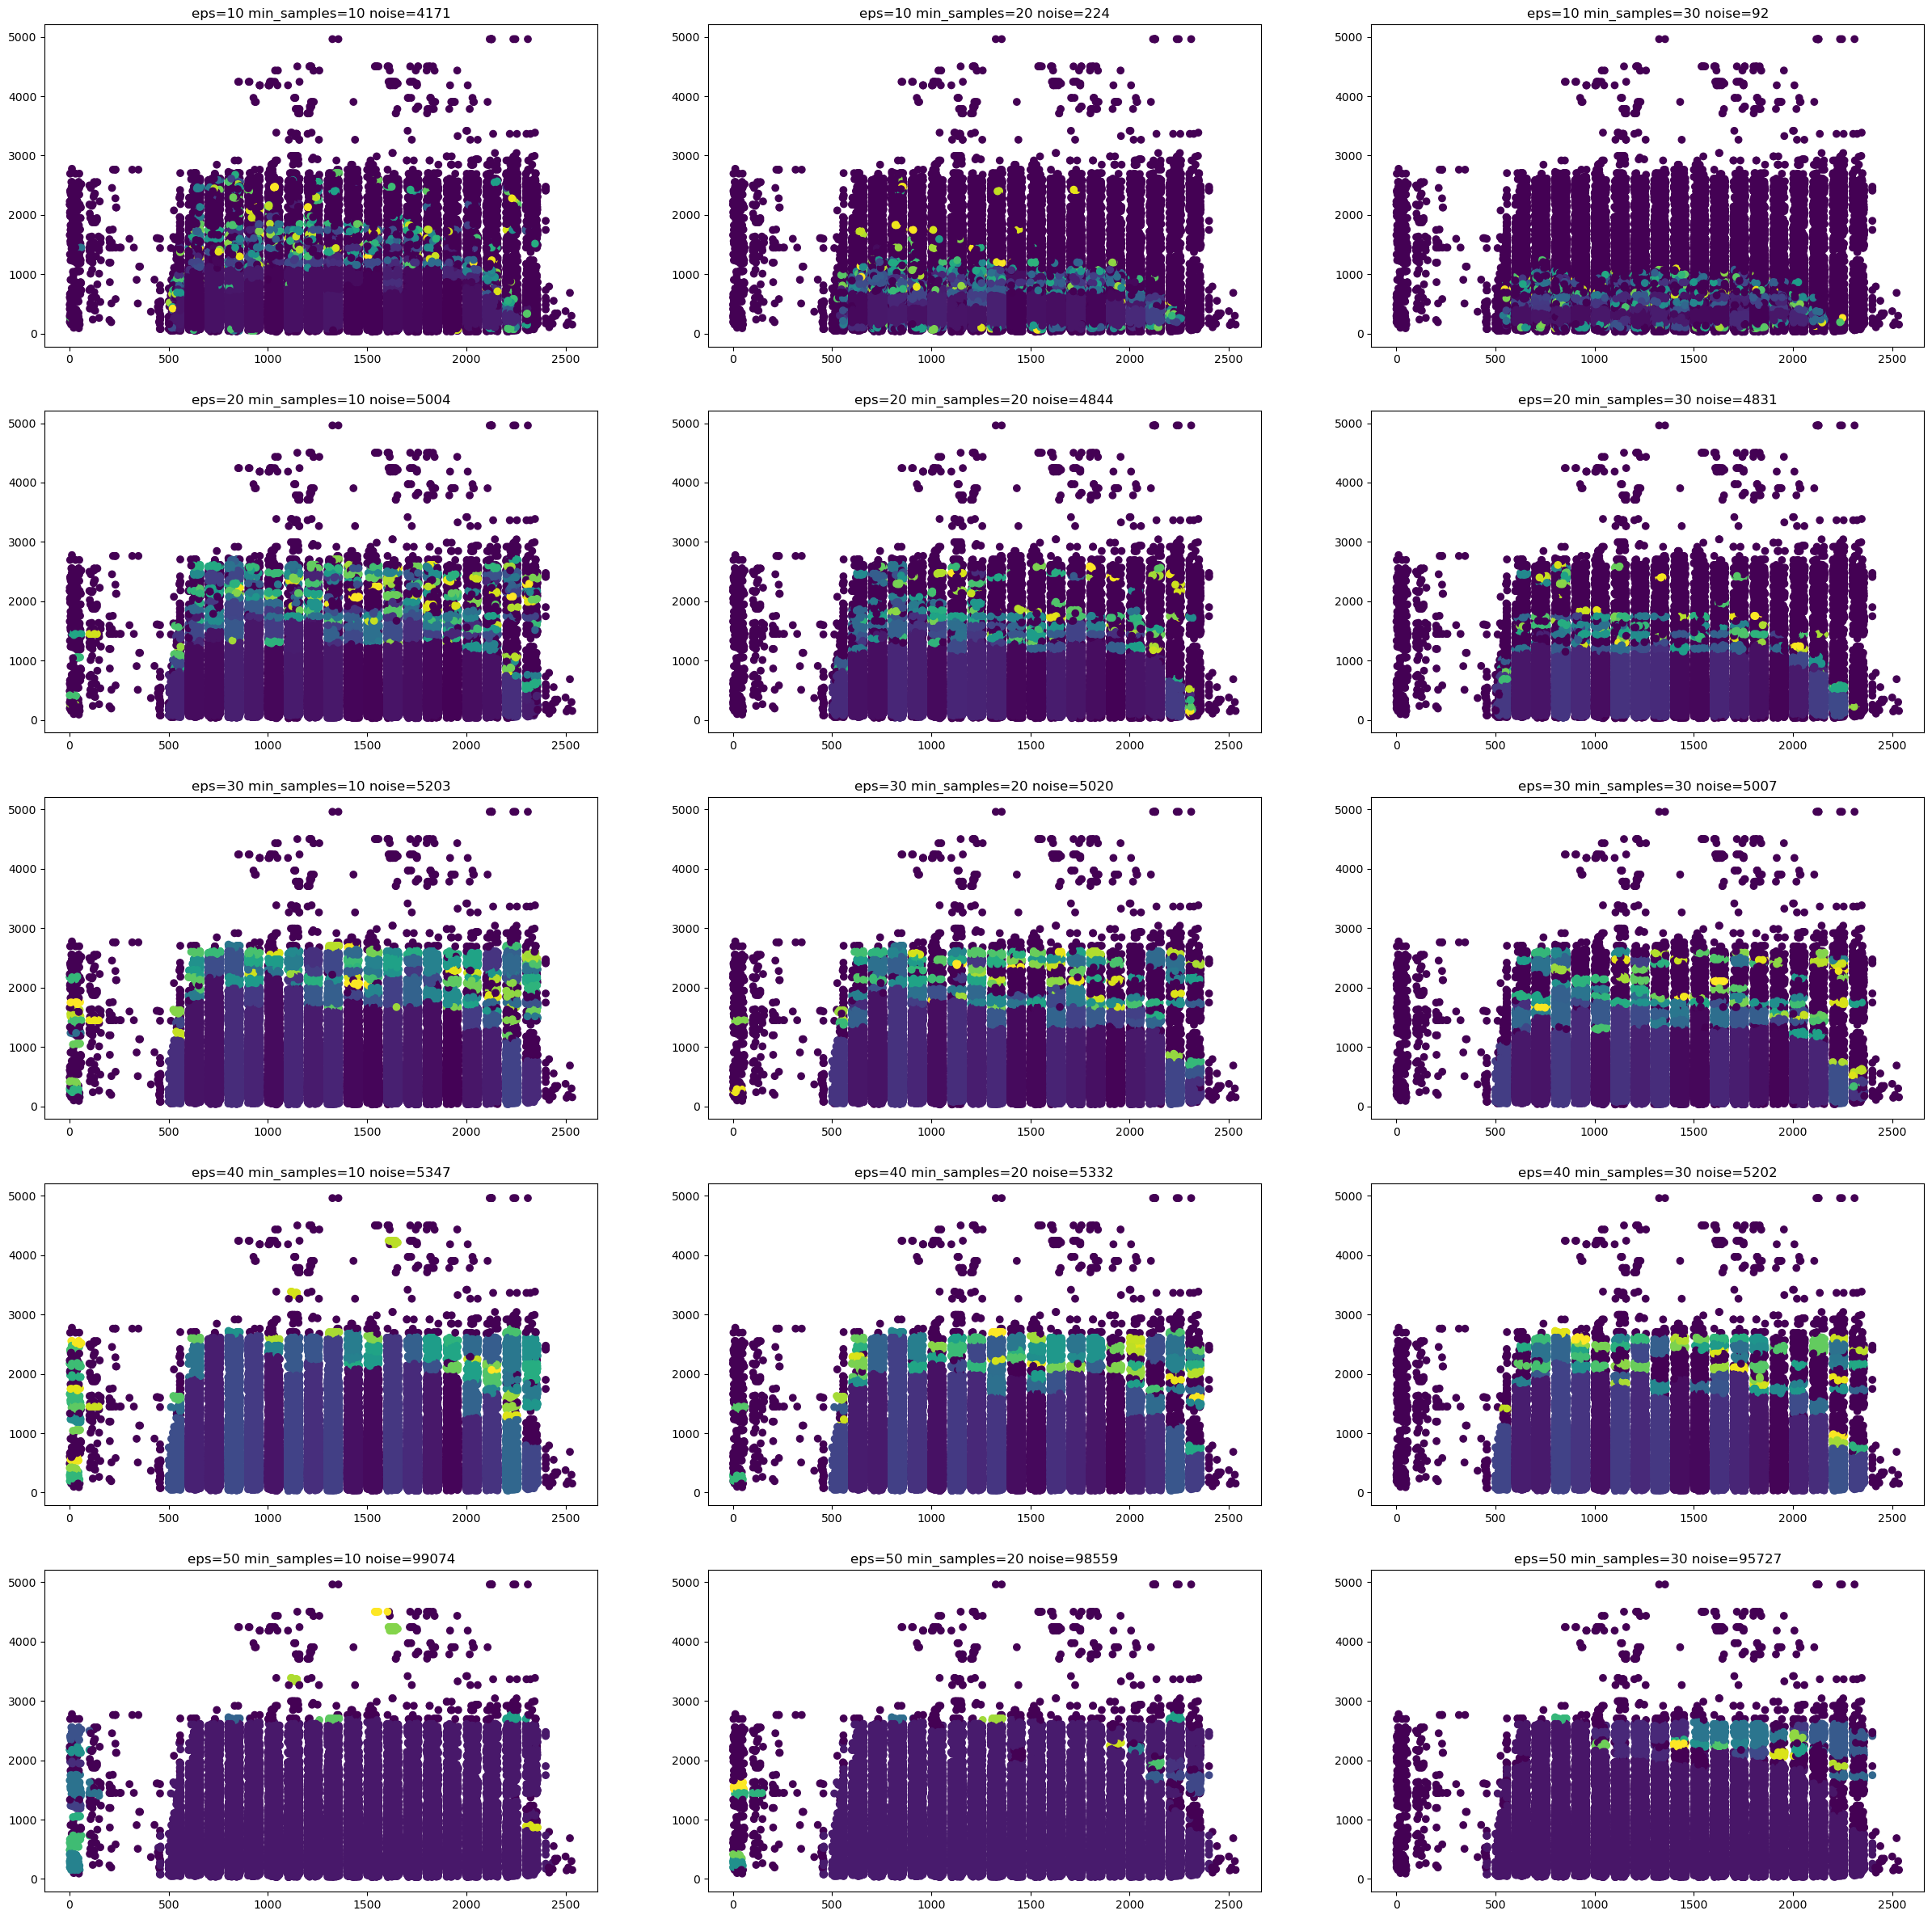

In [29]:
from itertools import product

plt.figure(figsize=(30, 30))
for i, setup in enumerate(product([10, 20, 30, 40, 50], [10, 20, 30])):
    plt.subplot(5, 3, i + 1)
    clusters = DBSCAN(eps=setup[0], min_samples=setup[1]).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title(f'eps={setup[0]} min_samples={setup[1]} noise={np.sum(clusters == 0)}')
plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [30]:
# восстановим изначальный датасет

train = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')

train['cluster_id'] = DBSCAN(eps=40, min_samples=10).fit_predict(train[['DepTime', 'Distance']].to_numpy())

train = preprocess(train)

X_train = train.drop(columns=['dep_delayed_15min'])
y_train = train['dep_delayed_15min']
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [31]:
cat_model = CatBoostClassifier(verbose=False)
cat_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cat_model.predict_proba(X_valid)[:, 1])

0.7447385438499418

Для референса - было 0.7455060962129153

__Ответ:__ Качество незначительно упало, можно даже списать на погрешность. Новая введенная переменная на самом деле практически не предоставляет какой-то новой информации - в конечном итоге это просто производная от времени отправления и расстояния. Более того, в своем текущем виде - числовое значение - признак по сути является "упорядоченным категориальным", хотя на самом деле номер кластера сам по себе никакой информации не несет. Ну и наконец: все шумовые точки в результате оказываются в одном гигантском кластере, что с точки зрения алгоритма должно указывать на их схожесть. Вполне очевидно, что эти точки на самом деле вообще друг на друга похожи не будут.
Таким образом все эти факторы могут привести и к ухудшению качества модели.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

Мне было как-то лень, поэтому вот визуализация по версии ruDALL-E
[Студент НИУ ВШЭ Нижний Новгород хорошо проводит лето на открытом воздухе](https://rudalle.ru/check_image/9c743ddb193148dda3403466eff4bb3d)

**+0.1 балла** за смешной мем по машинному обучению

Ну тут, конечно, не про машинное обучение, но все таки машинкой сгенерированное)
Из tg-канала [Neural Meduza](https://t.me/neuralmeduza):
"В Петербурге сгорел склад с фаршом. В пожаре погибли 43 человека (не больше тысячи). По словам пресс-службы губернатора Петербурга, пожарные успевали поесть"

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

Хороший курс, хорошие преподаватели, хорошие проверяющие и хорошие (нет) домашки))0) Были бы они еще проверены на тот момент, когда я это пишу.....